In [19]:
import logging, sys
logging.disable(sys.maxsize)
import pymongo
import pandas as pd
import statistics_utility as su
from web3 import Web3
import matplotlib
matplotlib.use('nbagg')
from evaluation.wallet_constant import BURNING_ADDRESSES
from evaluation.wallet_constant import LIQUIDITY_LOCKERS
from evaluation.evaluator import Evaluator
import evaluation.evaluation_config

from matplotlib import pyplot as plt
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


plt.rcParams['figure.dpi'] = 100

db_client = pymongo.MongoClient("mongodb://localhost:27017/")

statistics_db = db_client['big-dataset-50-50']
statistics_rescan_db = db_client['big-dataset-50-50-rescan']


# dataset_file = "./data/big_dataset_50_50.csv"
dataset_file = "./data/big_dataset_50_50.csv"
data = pd.read_csv(dataset_file)

dataset_file_2 = "./data/big_dataset_50_50.csv"
data_to_test = pd.read_csv(dataset_file_2)



In [21]:

features = {
#         'address': [], 
        'liquidity_amount': [], 
        'is_honeypot': [], 
        'highest_token_holder': [],
        'highest_liquidity_holder': [],
        'ownership_renounced': [],
        'verified_contract': [],
        'high_vulnerabilities': [],
        'get_combined_score': []
    }
# labels = {'get_combined_score': []}

for index, entry in data.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            

    impact, confidence = evaluator.get_highest_vulnerability()
    
#     features['address'].append(token['address'])
    features['liquidity_amount'].append(evaluator.get_eth_liquidity())
    features['is_honeypot'].append(token['honeypot']['IsHoneypot'])
    features['highest_token_holder'].append(evaluator.get_highest_token_holder_share())
    features['highest_liquidity_holder'].append(evaluator.get_highest_liquidity_holder_share())
    features['ownership_renounced'].append(evaluator.get_renounced_ownership())
    features['verified_contract'].append(evaluator.get_verified_contract())
    features['high_vulnerabilities'].append(impact)
    features['get_combined_score'].append(entry['Scam'])

    
features = pd.DataFrame(features)


# x_val = scaler.fit_transform(x_val)

features = features.sample(frac=1)

labels = pd.DataFrame(features['get_combined_score'])
print(features)

features = features.drop(['get_combined_score'], axis=1)

features = scaler.fit_transform(features)

# print(features.dtypes)
# print(features)
# print(labels.dtypes)
features

     liquidity_amount  is_honeypot  highest_token_holder  \
239      6.055323e-01        False             72.828230   
301      1.121172e-01        False             85.808794   
51       3.609418e+02        False             12.940041   
298      1.362425e+00        False              5.610168   
308      2.634343e+01        False             18.579048   
..                ...          ...                   ...   
104      3.120000e+00        False              0.987158   
112      4.905965e+01        False             16.109101   
341      6.000000e-18        False             88.033283   
20       8.445590e-01        False             20.952493   
41       1.943823e+00        False              1.870600   

     highest_liquidity_holder  ownership_renounced  verified_contract  \
239                     36.53                  1.0               True   
301                    100.00                  1.0               True   
51                     100.00                  1.0          

array([[-0.16659426, -0.48441412, -0.11162911, ...,  0.61876614,
         0.32679675, -0.9926664 ],
       [-0.16763427, -0.48441412, -0.11162911, ...,  0.61876614,
         0.32679675,  0.01894402],
       [ 0.59291784, -0.48441412, -0.11162911, ...,  0.61876614,
         0.32679675,  0.01894402],
       ...,
       [-0.16787059, -0.48441412, -0.11162911, ...,  0.61876614,
         0.32679675,  0.01894402],
       [-0.16609044, -0.48441412, -0.11162911, ..., -0.77345768,
         0.32679675, -0.9926664 ],
       [-0.16377342, -0.48441412, -0.11162911, ...,  0.61876614,
         0.32679675,  1.03055443]])

[12:12:36] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators", "normalize_type", "rate_drop", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


81.68 %


<IPython.core.display.Javascript object>


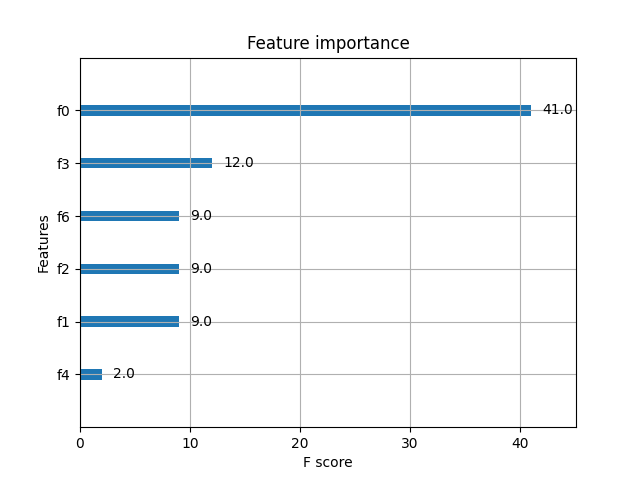

In [22]:
x_train, x_val, y_train, y_val = train_test_split(features, labels, train_size=80)


d_train = xgb.DMatrix(x_train, y_train)
d_test = xgb.DMatrix(x_val, y_val)

params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.1,
    'sample_type': 'uniform', # uniform, weighted
    'normalize_type': 'tree',
    'objective': 'binary:hinge',# binary:logistic binary:hinge
    'rate_drop': 0.1,
    'n_estimators': 500
}

xgb_clf = xgb.train(params_1, d_train)



preds = xgb_clf.predict(d_test)

print(np.round(accuracy_score(y_val, preds)*100, 2), '%')

xgb.plot_importance(xgb_clf)
plt.show()

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.999992         0.027457         0.999877        0.110380
1          0.999992         0.027457         0.999877        0.110380
2          0.643362         0.335633         0.660198        0.261799
3          0.173562         0.263591         0.318461        0.319285
4         -0.131107         0.064434         0.052717        0.120043
81.68 %


<IPython.core.display.Javascript object>


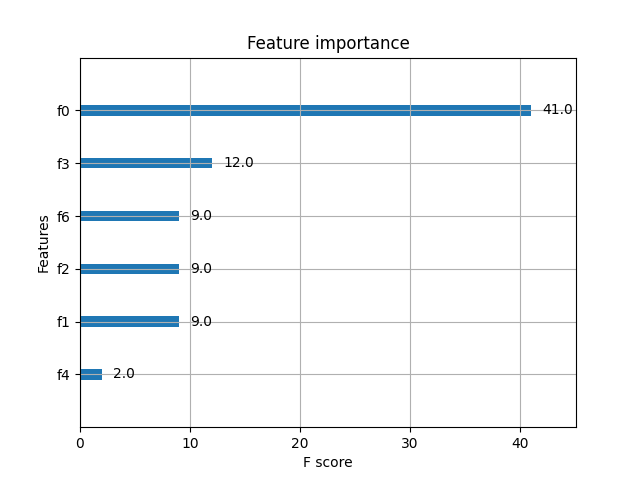

In [23]:
features = scaler.fit_transform(features)
labels = scaler.fit_transform(labels)


dmatrix_data = xgb.DMatrix(features, labels)

params = {
    'objective': 'binary:hinge',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
}

cross_val = xgb.cv(
    params=params,
    dtrain=dmatrix_data, 
    nfold=5,
    num_boost_round=50, 
    early_stopping_rounds=10, 
    metrics='error', 
    as_pandas=True, 
    seed=42)

print(cross_val.head())

preds = xgb_clf.predict(d_test)
print(np.round(accuracy_score(y_val, preds)*100, 2), '%')


xgb.plot_importance(xgb_clf)
plt.show()


In [24]:


test_data = {
#         'address': [], 
        'liquidity_amount': [], 
        'is_honeypot': [], 
        'highest_token_holder': [],
        'highest_liquidity_holder': [],
        'ownership_renounced': [],
        'verified_contract': [],
        'high_vulnerabilities': [],
        'get_combined_score': []
    }
# labels = {'get_combined_score': []}

for index, entry in data_to_test.iterrows():
    token = statistics_db.scanned_tokens.find_one({'address': Web3.toChecksumAddress(entry['address'])})

    evaluator = Evaluator(token, evaluation.evaluation_config.DEFAULT_CONFIG)            

    impact, confidence = evaluator.get_highest_vulnerability()
    
#     features['address'].append(token['address'])
    test_data['liquidity_amount'].append(evaluator.get_eth_liquidity())
    test_data['is_honeypot'].append(token['honeypot']['IsHoneypot'])
    test_data['highest_token_holder'].append(evaluator.get_highest_token_holder_share())
    test_data['highest_liquidity_holder'].append(evaluator.get_highest_liquidity_holder_share())
    test_data['ownership_renounced'].append(evaluator.get_renounced_ownership())
    test_data['verified_contract'].append(evaluator.get_verified_contract())
    test_data['high_vulnerabilities'].append(impact)
    test_data['get_combined_score'].append(entry['Scam'])

    
test_data = pd.DataFrame(test_data)

test_data_labels = pd.DataFrame(test_data['get_combined_score'])

test_data = test_data.drop(['get_combined_score'], axis=1)

test_data = scaler.fit_transform(test_data)

test_matrix = xgb.DMatrix(test_data, test_data_labels)


preds2 = xgb_clf.predict(test_matrix)

print(np.round(accuracy_score(test_data_labels, preds2)*100, 2), '%')


85.09 %
